<a href="https://colab.research.google.com/github/muinul-official/Data-Mining-G13/blob/hannah-feature-engineering/PredictionModelXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WIE3007 Data Mining Project

* Predictive Model Name :
* Made by : Hannah bt Arham Rahimy (22002434)

## Install & import libraries

In [1]:
!pip -q install xgboost

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)
from xgboost import XGBClassifier

## Load model-ready datasets

In [2]:
X = pd.read_csv("X_features.csv")

y_df = pd.read_csv("y_target.csv")
# y might be 1 column; convert jadi list
y = y_df.iloc[:, 0]

print(X.shape, y.shape)
print(y.value_counts())

(1200, 45) (1200,)
churn
0    925
1    275
Name: count, dtype: int64


## Train/test split (fair comparison)

In [3]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    #same split everytime
    random_state=42,
    #keep churn ratio similar in train and test
    stratify=y
)

## Build XGBoost Model

In [4]:
#handle class imbalance
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(3.3636363636363638)

In [5]:
xgb = XGBClassifier(
    # number of trees (more trees=more learning)
    n_estimators=400,
    # how big each correction steps are (small safer tapi need more trees)
    learning_rate=0.05,
    # how complex each tree can get (too deep = can overfit)
    max_depth=4,
    # each tree sees only 80% of rows = reduce overfitting
    subsample=0.8,
    # each tree sees only 80% of features = reduce overfitting
    colsample_bytree=0.8,
    # regularization (penalize overly complex model)
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0,
    scale_pos_weight=scale_pos_weight,
    # binary classification + outputs probabilities
    objective="binary:logistic",
    # tell what to optimize during training
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluate

In [6]:
# predict
# predict() : give class (0/1)
# predict_proba() : gives prob
#[:,1] : probability of class 1 (churn)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# evaluation
#Accuracy: overall correct %
#Precision: when model says churn, how often it’s right
#Recall: how many real churners it successfully catches (important for churn)
#F1: balance between precision & recall
#ROC-AUC: how good the model is at ranking churn risk using probabilities
#Confusion matrix: counts of TP/TN/FP/FN

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("F1:", f1)
print("Precision:", prec)
print("Recall:", rec)
print("ROC-AUC:", auc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0
ROC-AUC: 1.0

Confusion Matrix:
 [[185   0]
 [  0  55]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       185
           1       1.00      1.00      1.00        55

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



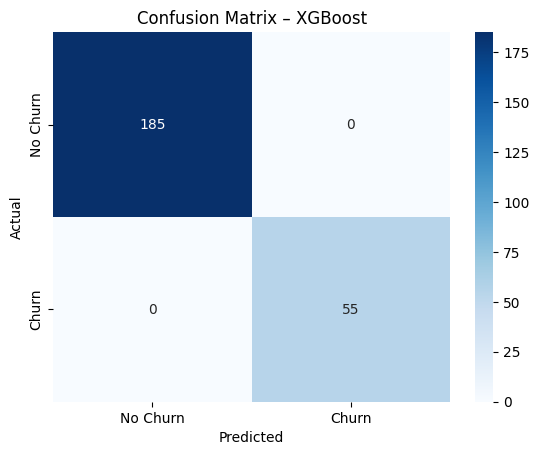

In [11]:
# confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost")
plt.show()

## Feature Importance

In [7]:
#Which features did the model rely on most when splitting trees?

importances = xgb.feature_importances_
feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)

feat_imp.head(15)

,feature,importance
22,churn_probability,0.379865
3,frequency,0.175818
9,email_open_rate,0.169916
16,review_sentiment_score,0.065455
6,total_orders,0.046679
21,order_frequency_per_month,0.030893
12,chat_sentiment_score,0.030887
4,monetary_value,0.029887
18,sentiment_score_avg,0.013855
1,account_age_days,0.010758


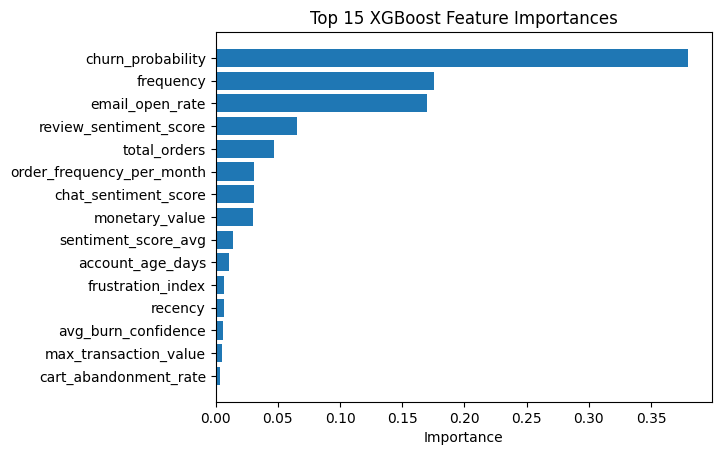

In [8]:
import matplotlib.pyplot as plt

top = feat_imp.head(15)
plt.figure()
plt.barh(top["feature"][::-1], top["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 15 XGBoost Feature Importances")
plt.show()

In [9]:
threshold = 0.35
y_pred_t = (y_proba >= threshold).astype(int)

print("Threshold:", threshold)
print("F1:", f1_score(y_test, y_pred_t))
print("Precision:", precision_score(y_test, y_pred_t))
print("Recall:", recall_score(y_test, y_pred_t))
print(confusion_matrix(y_test, y_pred_t))

Threshold: 0.35
F1: 1.0
Precision: 1.0
Recall: 1.0
[[185   0]
 [  0  55]]
